# About Formula 1

Formula 1 is the premier class of international autoracing and one of the fastest motorsports in the world with the cars regularly reaching speeds of over 200 mph (322 km/h) during races. 

The Formula One World Championship, previously called the World Drivers' Championship, is now in its 72nd season, and thanks to recent additions of multiple television deals around the world Formula 1 is possibly more popular now more than ever. 

Being a fairly new spectator of the sport, having only been watching the last 3 or 4 seasons, I wanted to put together some general questions a novice like myself might ask to learn more about the sport. These should be fairly straight-forward and easy to answer with the use of data science techniques.

After answering the straight-forward questions I will then create a predictive model to help answer the question, "What effect does being on pole (starting the race in first place) have on a driver's final position at the race's end?"

# About the dataset

The data being used were resourced from the kaggle.com dataset **Formula 1 World Championship (1950 - 2021)**. The data were orginally from three csv files which included driver info, circuit info, and race results.

# Questions

In this presentation I am trying to answer a few simple questions using the data provided.
1. How many drivers have participated in Formula 1?
2. What countries have produced the most drivers?
3. Has a race ever been won by an American?
4. Who are the most successful constructors (teams)?
5. Who are the most successful drivers?
6. What effect does being on pole (starting the race in first place) have on a driver's final position at the race's end?
7. How likely is a driver to win at Monaco if he starts on the pole?

In [1]:
# import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas_profiling

In [2]:
# import the data from the 3 csv files

results = pd.read_csv('results.csv')
circuits = pd.read_csv('circuits.csv')
drivers = pd.read_csv('drivers.csv')
constructor_standings = pd.read_csv('constructor_standings.csv')
constructors = pd.read_csv('constructors.csv')

In [3]:
#pandas_profiling.ProfileReport(results)

## How many drivers have participated in F1?

Starting off I explore the drivers dataframe to find out the number of drivers who have participated in F1.

In [4]:
# get a quick view of the dataframe

drivers.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [5]:
# find the number of unique values for driverId

print('There have been '+str(len(drivers['driverId'].unique()))+' drivers participate in Formula 1 since 1950.')

There have been 853 drivers participate in Formula 1 since 1950.


## What countries have produced the most drivers?

Now I want to know what countries have produced the most drivers.

In [6]:
# list the unique values that appear in nationality

drivers['nationality'].unique()

array(['British', 'German', 'Spanish', 'Finnish', 'Japanese', 'French',
       'Polish', 'Brazilian', 'Italian', 'Australian', 'Austrian',
       'American', 'Dutch', 'Colombian', 'Portuguese', 'Canadian',
       'Indian', 'Hungarian', 'Irish', 'Danish', 'Argentine', 'Czech',
       'Malaysian', 'Swiss', 'Belgian', 'Monegasque', 'Swedish',
       'Venezuelan', 'New Zealander', 'Chilean', 'Mexican',
       'South African', 'Liechtensteiner', 'Rhodesian',
       'American-Italian', 'Uruguayan', 'Argentine-Italian', 'Thai',
       'East German', 'Russian', 'Indonesian'], dtype=object)

I see that while there are 41 unique values two of them - 'American-Italian' and 'Argentine-Italian' - contain multiple countries of nationality. 

In [7]:
# find out which drivers are listed as 'American-Italian' and 'Argentine-Italian'

drivers[(drivers['nationality']=='American-Italian') | (drivers['nationality']=='Argentine-Italian')]

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
491,491,thiele,\N,\N,Alfonso,Thiele,1920-04-05,American-Italian,http://en.wikipedia.org/wiki/Alfonso_Thiele
573,573,tomaso,\N,\N,Alessandro,de Tomaso,1928-07-10,Argentine-Italian,http://en.wikipedia.org/wiki/Alessandro_de_Tomaso


A quick google search will show that both drivers participated in autosports under the flags of each nation. I'll leave their nationalities as is.

In [8]:
# find the number of drivers under each nationality

# create a bar plot

nationality_count = drivers['nationality'].value_counts().to_frame('Counts').reset_index()
nationality_count.rename(columns={'index':'Nationality'}, inplace=True)

nationality_count.head()

,Nationality,Counts
0,British,165
1,American,157
2,Italian,99
3,French,73
4,German,50


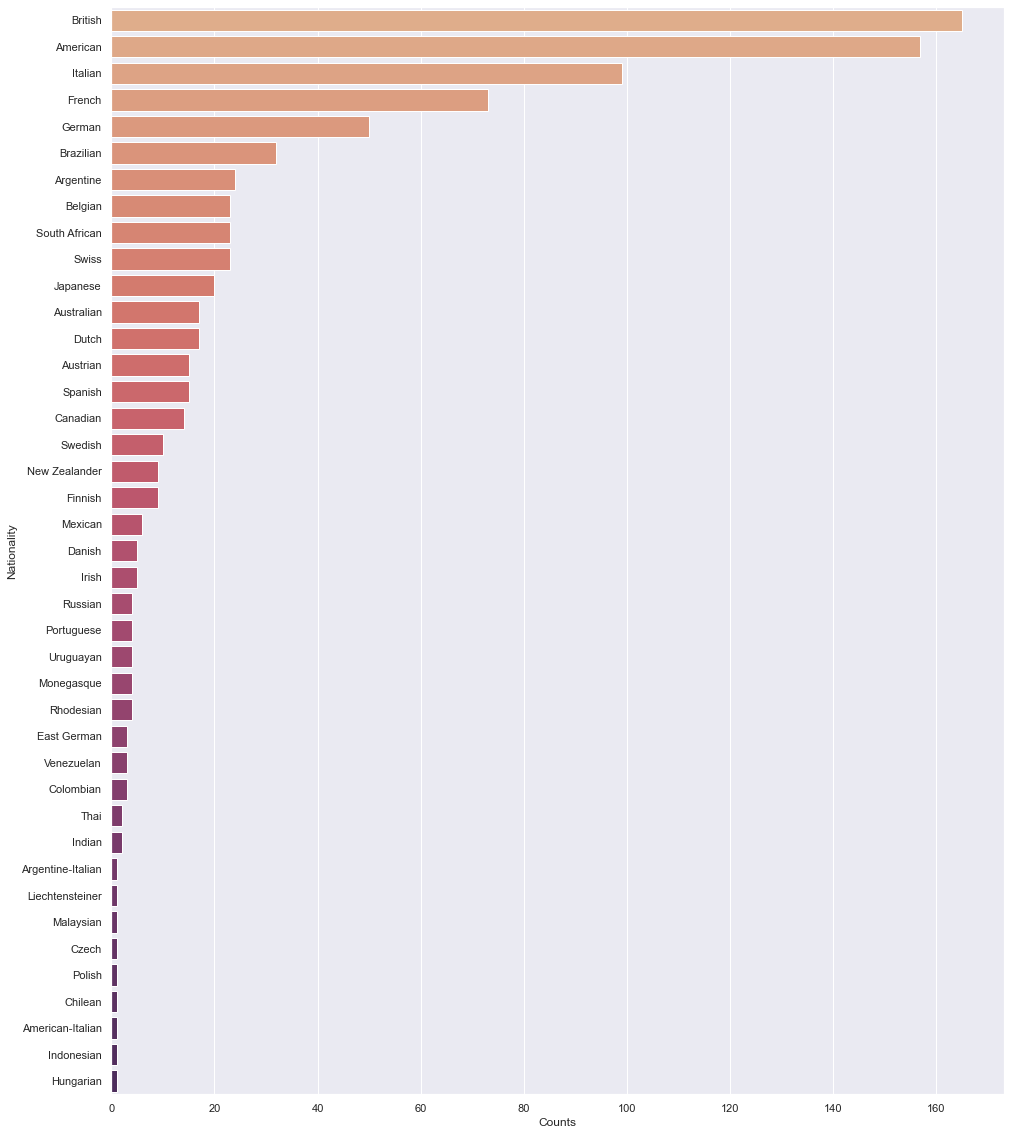

In [9]:
plt.figure(figsize=(16,20))
sns.barplot(data=nationality_count, y='Nationality', x='Counts', palette='flare')
plt.show()

With the popularity of F1 in Europe it seems typical to have 4 of the top 5 driver producing countries located in this region. What is very surprising to find is that the United States has produced the second most drivers with 157, trailing only Britain which has produced 165.

## Has an American ever won an F1 race?

With Americans taking second place in total number of drivers I'm not curious to find out if an American has ever won a race.

In [10]:
# merge results dataframe and drivers dataframe 

results_n_drivers = results.merge(drivers, how='inner', on='driverId')

In [11]:
# create a dataframe that includes American drivers that have finished 1st

US_winners = results_n_drivers[(results_n_drivers['positionOrder']==1) & (results_n_drivers['nationality']=='American')]

In [12]:
# print the number of American winners and the number of races they've won

print('There have been ' + str(len(US_winners['forename'].unique())) + ' American winners')
print('')
print('Together they have won ' + str(US_winners['positionOrder'].count()) + ' races')

There have been 15 American winners

Together they have won 33 races


## Who are the most successful constructors (teams)?

Find the top 5 constructors with the most race wins and how many average points do they receive per win

In [13]:
# combine constructor results and constructors on constructorId

all_constructors = constructor_standings.merge(constructors, how='inner', on='constructorId')

# remove unecessary columns from the dataframe

all_constructors = all_constructors.drop(all_constructors.columns[[0, 5, 7, 10]], axis=1)

In [14]:
# change points to constructor points

new_cols = all_constructors.columns.values
new_cols[2] = 'con_points'
all_constructors.columns = new_cols

In [15]:
# merge results and all_constructors on raceId and constructorId

constructor_results = results.merge(all_constructors, how='inner', on=['raceId','constructorId'])

In [16]:
constructor_results.head()

,resultId,raceId,driverId,constructorId,grid,positionOrder,points,laps,statusId,con_points,position,wins,name,nationality
0,7554,1,18,23,1,1,10.0,58,1,18.0,1,1,Brawn,British
1,7555,1,22,23,2,2,8.0,58,1,18.0,1,1,Brawn,British
2,7556,1,15,7,20,3,6.0,58,1,11.0,2,0,Toyota,Japanese
3,7557,1,10,7,19,4,5.0,58,1,11.0,2,0,Toyota,Japanese
4,7558,1,4,4,10,5,4.0,58,1,4.0,3,0,Renault,French


In [ ]:
# which constructors have won the most season championships

# find the constructor name for the max number of points for each unique season

Who are the most successful drivers?

What effect does being on pole (starting the race in first place) have on a driver's final position at the race's end?

How likely is a driver to win at Monaco if he starts on the pole?